# Colouring Black & White Images Using CNN

Image colourisation is the process of taking a black and white image as an input and returning an automatically coloured image as the output. Previous methods for image colourisation relied on manual human annotation and often produced desaturated results that were not believable as true colourisations.

In this notebook, we're gonna use a CNN (Convolutional Neural Network) model for colouring vintage black and white photos. This approach is a pre-trained model by [Richard Zhang](https://richzhang.github.io/colorization/), where he implemented an Artificial Intelligent (AI) approach as a feed-forward pass in a CNN at test time then trained on over a million colour images. The reason for choosing this model over to train our own model is because the author has trained his model using millions of images. Due to the lack of such a large number of images and lack of computation power to train such a large number of images, we are using his pre-trained model.

Here a photo of a Canadian tank advancing during the Battle of Caen July 10th 1944:

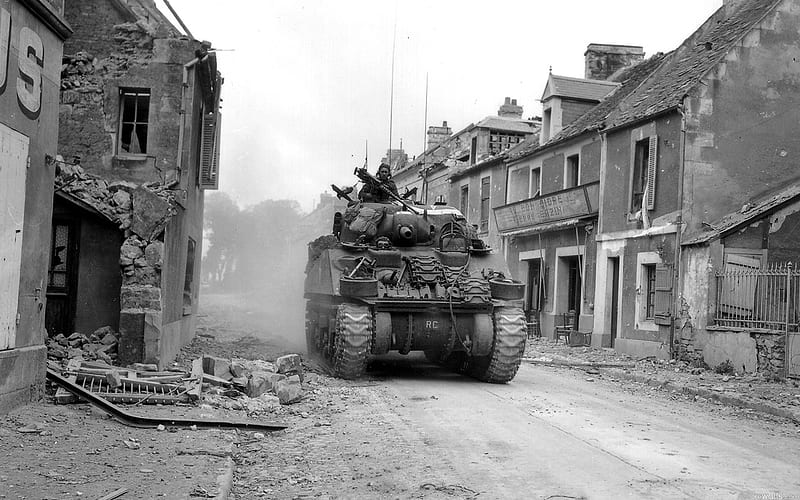

And its colourised version using the models developed using these AI technics:

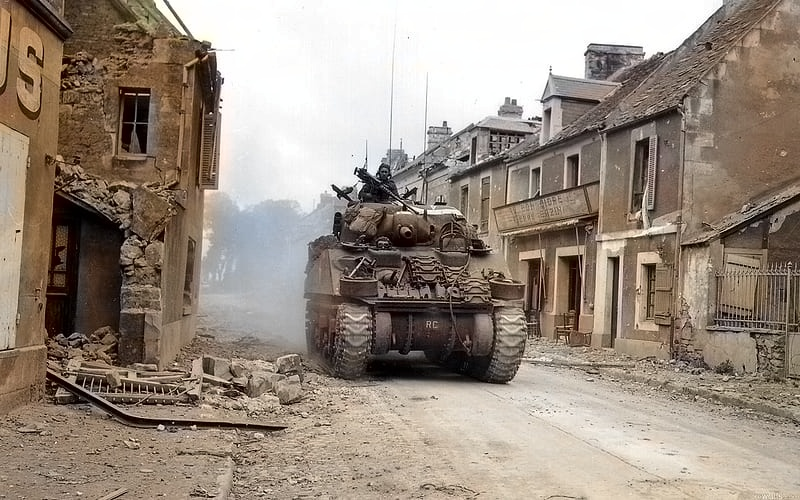

So, how this system works?

Now as we are getting intensity as input and we have to guess colours, we can't use RGB colour space as it doesn't have information regarding illumination. We have two other options: either YCbCr colour space or Lab colour space as both Y and L channel encodes the information regarding illumination. We will using Lab colour space in this notebook.

What is Lab Colour Space?
Similar to the RGB colour space, the Lab colour space has three channels. But unlike the RGB colour space, Lab encodes colour information differently i.e.,

L-channel: encodes light intensity only
a channel: encodes green-red
b channel: encodes blue-red

Since the L channel encodes only the intensity, we can use the L channel as our grayscale input to the network. From there the network must learn to predict the a and b channels. Given the input L channel and the predicted ab channels we can then form our final output image.

In our system, we will use the L channel of our image as input to our model to predict ab channel values and then rejoin it with the L channel to generate our final image.

The entire (simplified) process can be summarised as:
- Load the model and the convolution/kernel points
- Convert the input image to the Lab colour space
- Use the L channel as the input to the network and train the network to predict the ab channels
- Combine the input L channel with the predicted ab channels
- Convert the Lab image to RGB

To proceed with further explanation on the colouring of black & white images, we need to download these 3 files:
- __[colorization_release_v2.caffemodel](https://people.eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2.caffemodel/):__ The pre-trained model stored in the Caffe framework’s format that can be used to predict new unseen data.
- __colorization_deploy_v2.prototxt:__ Consists of different parameters that define the network and it also helps in deploying the Caffe model.
- __pts_in_hull.npy:__ The NumPy file that stores the cluster center points in NumPy format. It consists of 313 cluster kernels, i.e (0-312).

You can download the *colorization_deploy_v2.prototxt* and *pts_in_hull.npy* files from my [github](https://github.com/just4data/Coloring-Black-White-Images-Using-CNN/) then load them at your directory folder.

Now, let's begin the step by step explanation for the conversion of black & white image into a coloured image. First, we need to import the libraries that we will be using.

In [1]:
# import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

Then define model paths, You can use any image, I'm using a 1944 B&W photo of British army in Greece. The photo is available on my GitHub.

In [2]:
# path to the Caffe prototxt file
prototxt = 'colorization_deploy_v2.prototxt'
# path to the Caffe pre-trained model
model = 'colorization_release_v2.caffemodel'
# path to a NumPy cluster center points file
points = 'pts_in_hull.npy'
# path to our input black & white image
bw_image = 'test_image.jpg'

Next, we will read the pre-trained model we talked about. We will provide the path where the 3 files ".cafffemodel", ".prototxt", ".npy" and the testing image is located to load our model and cluster centers into memory.

In [3]:
net = cv2.dnn.readNetFromCaffe(prototxt, model)
pts = np.load(points)

Now, we loaded our Caffe model directly from the command line argument values. OpenCV can read Caffe models via the cv2.dnn.readNetFromCaffe function. The function cv2.dnn.readNetFromCaffe() accepts two parameters:
- prototxt – path to ".prototxt" file
- caffe_model – path to ".caffemodel" file

Then, we loaded the cluster center points directly from the command line to the points file using NumPy.

Next step is to fetch the layer IDs from the last layer of the caffee model by using the function ".getLayerId()". The ".getLayerId()" takes one parameter.

In [4]:
layer1 = net.getLayerId('class8_ab')
print(layer1)
layer2 = net.getLayerId('conv8_313_rh')
print(layer2)

55
53


To understand how we got the above two output names "class8_ab" and "conv8_313_rh", we got them from the last part of the code in ".prototxt" file. As we can see below, the number of outputs is two and above that are the output names.

In [5]:
# read the last 20 lines of colorization_deploy_v2.prototxt file
with open('colorization_deploy_v2.prototxt', 'r') as file:
    for line in (file.readlines() [-20:]):
        print(line)

# ********************

# ***** Decoding *****

# ********************

layer {

  name: "class8_ab"

  type: "Convolution"

  bottom: "class8_313_rh"

  top: "class8_ab"

  convolution_param {

    num_output: 2

    kernel_size: 1

    stride: 1

    dilation: 1

  }

}

layer {

  name: "Silence"

  type: "Silence"

  bottom: "class8_ab"

}


Next, we will transposeour NumPy file and reshape the cluster centers stored in them as a 1×1 matrix, then add it to our model.

In [6]:
pts = pts.transpose().reshape(2, 313, 1, 1)
net.getLayer(layer1).blobs = [pts.astype('float32')]
net.getLayer(layer2).blobs = [np.full([1, 313], 2.606, dtype = 'float32')]

Next step is to use OpenCV to read our test image from the path, scale it and convert it to Lab: Note that we will first convert the image to grayscale. This step is not really necessary, but I realise that some B&W photos, especially the old ones, could have some treatment during the years, so, better to clean them a little.

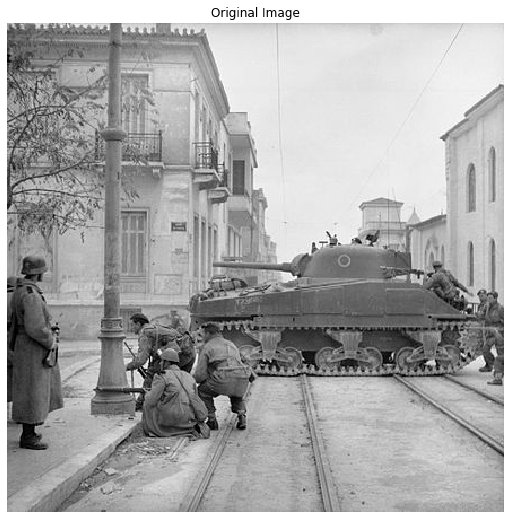

In [7]:
# read image from the path
test_image = cv2.imread(bw_image)
# convert image into gray scale
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
# convert image from gray scale to rgb format
test_image = cv2.cvtColor(test_image, cv2.COLOR_GRAY2RGB)
# check image using matplotlib
plt.imshow(test_image)
plt.rcParams['figure.figsize'] = [16, 9]
plt.title('Original Image')
plt.axis('off')
plt.show()

Next, we will perform the scaling operation by normalising the image pixels between 0-1. Then convert the image format to Lab space. Then resize the image into 224×224 shape because the pre-trained model takes the input image as (224,224) size. The cv2.split() function splits the image into three channels: L, a and b.

In [8]:
# normalise the image
normalised= test_image.astype("float32") / 255.0
# convert the image into LAB
lab_image = cv2.cvtColor(normalised, cv2.COLOR_RGB2LAB)
# resize the image
resized = cv2.resize(lab_image, (224, 224))

We can extract the L-channel from the Lab image by using its index number. After that, we are performing the mean subtraction on the L channel of the image.

In [9]:
# extract the value of L for Lab image
L = cv2.split(resized)[0]
L -= 50   # OR we can write L = L - 50

Now we are passing the L-channel as an input to our model then predicting the a and b values from the model.

In [10]:
# set the input
net.setInput(cv2.dnn.blobFromImage(L))
# findi the values of a and b
ab = net.forward()[0, :, :, :].transpose((1, 2, 0))
# resize
ab = cv2.resize(ab, (test_image.shape[1], test_image.shape[0]))

Next, the L-channel is extracted again but from the original Lab image, because the dimensions of all three planes(L, a, b) should be the same. Then we combine the L-channel with a and b by using Numpy to get the Lab coloured image. Finally, we use Matplotlib to show the image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


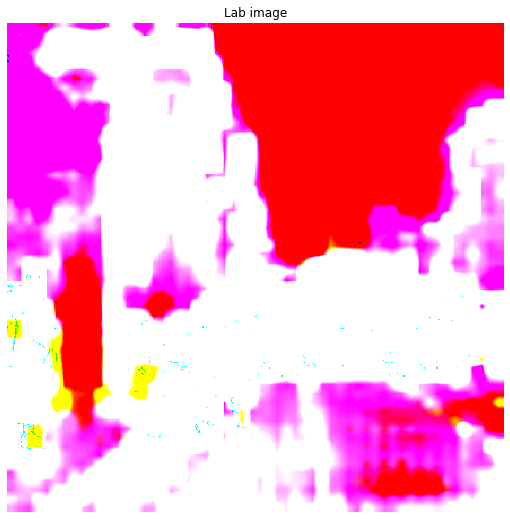

In [11]:
L = cv2.split(lab_image)[0]
# combining L, a, b
Lab_coloured = np.concatenate((L[:, :, np.newaxis], ab), axis = 2)
# check the Lab image
plt.imshow(Lab_coloured)
plt.rcParams['figure.figsize'] = [16, 9]
plt.title('Lab image')
plt.axis('off')
plt.show()

Now we've obtained the Lab coloured image, but the image is not understandable. So, we need to convert it (the Lab image) into RGB format and see the result.

In [12]:
# convert Lab image to RGB_colored
RGB_coloured = cv2.cvtColor(Lab_coloured, cv2.COLOR_LAB2RGB)

Then we will use np.clip() for clipping the RGB image between 0 and 1 because RGB works that way. Clipping means, if the interval is [0,1], then all the values smaller than zero will become zero, and all the values larger than one will become one. If we remember, we normalised our image pixels between 0-1 earlier. Now, we're changing the image pixels back between 0-255. 

In [13]:
# limits the values in array
RGB_coloured = np.clip(RGB_coloured, 0, 1)
# change the pixel intensity back to [0,255]
RGB_coloured = (255 * RGB_coloured).astype('uint8')

Now, after plotting the RGB image by using Matplotlib, we will get a perfectly coloured image for our black & white test image.

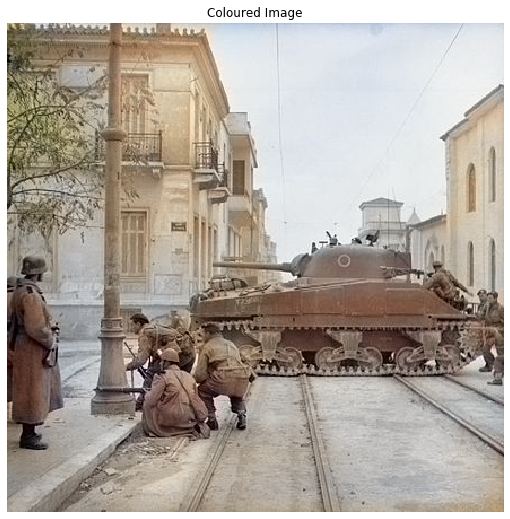

In [14]:
# check the final coloured image
plt.imshow(RGB_coloured)
plt.rcParams['figure.figsize'] = [16, 9]
plt.title('Coloured Image')
plt.axis('off')
plt.show()

To save the coloured image, first, we need convert it from RGB format to BGR format and then using OpenCV to save the image at the directory path. As we can see cv2.imwrite() takes to arguments, i.e. path (the location where the file should be saved) and RGB_BGR (the file).

In [15]:
# converting RGB to BGR
RGB_BGR = cv2.cvtColor(RGB_coloured, cv2.COLOR_RGB2BGR)
# save the image in desired path
# cv2.imwrite('../'+bw_image, RGB_BGR)
cv2.imwrite('coloured_image.jpg', RGB_BGR)

True

Great! Try with other B&W photos and see how amazing Artificial Intelligence can be!

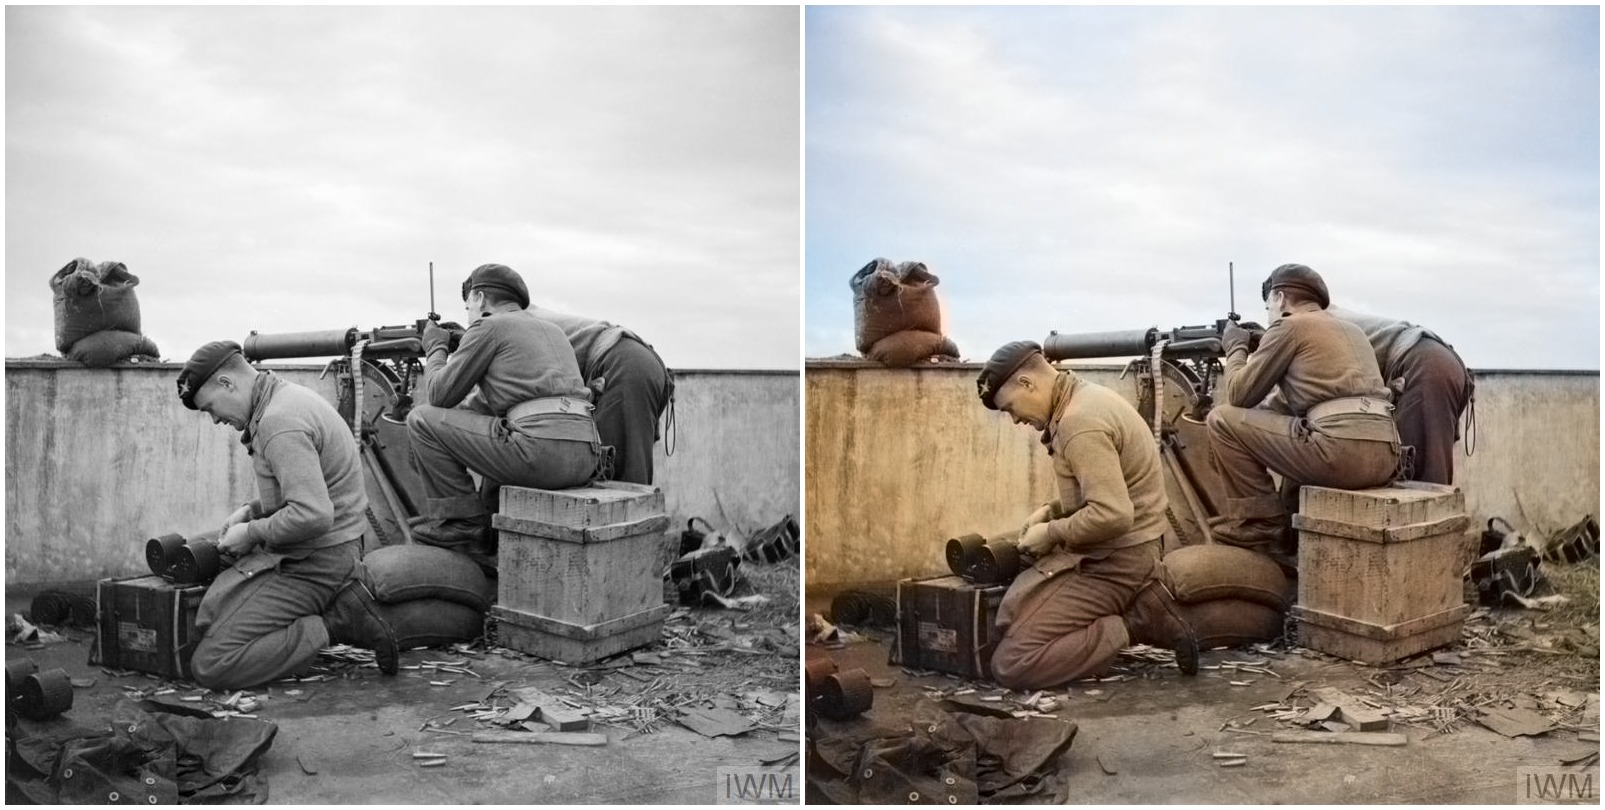

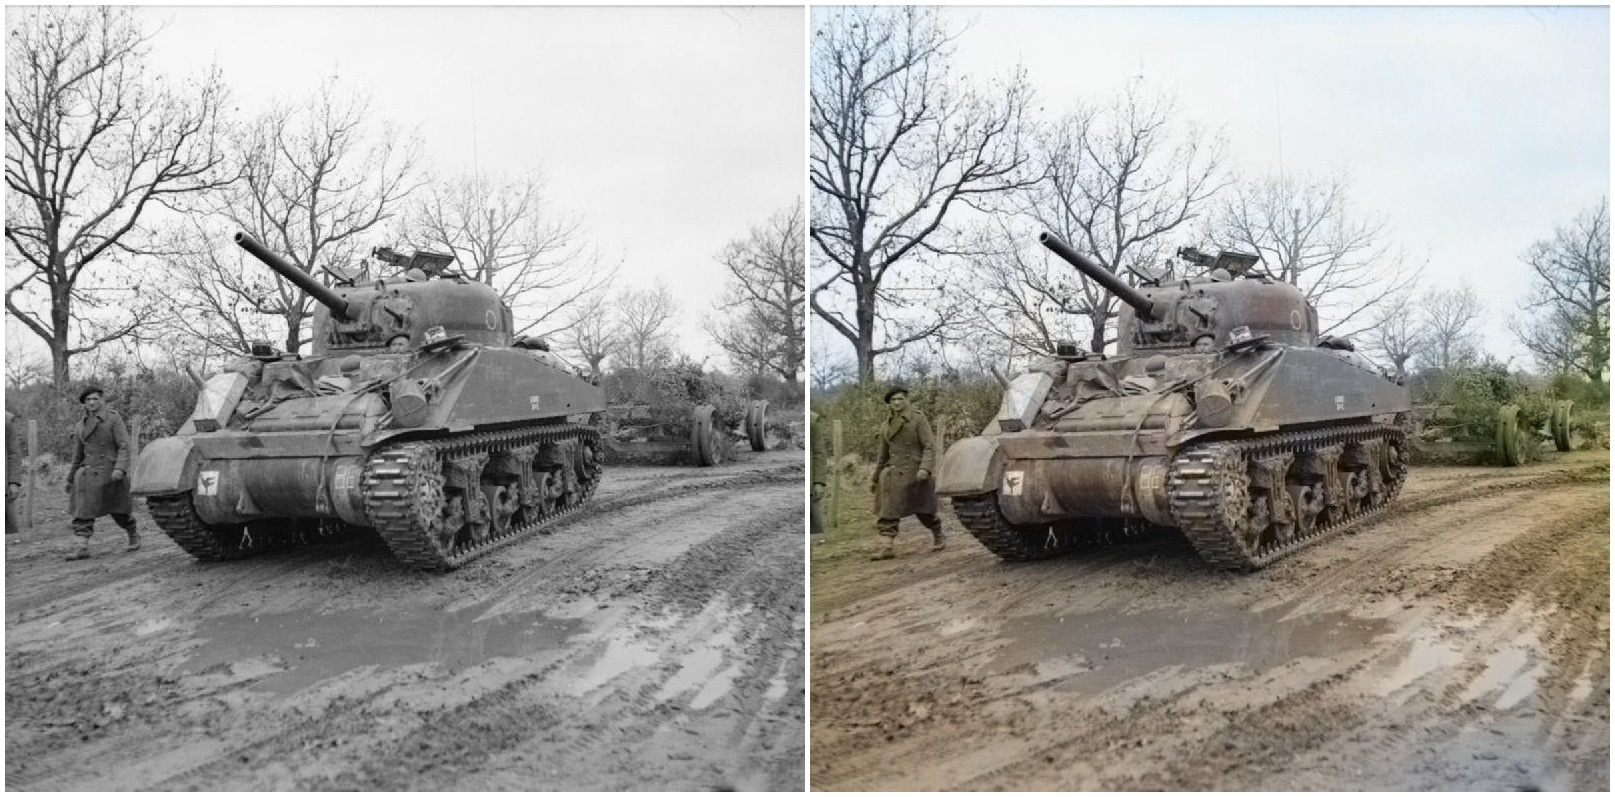

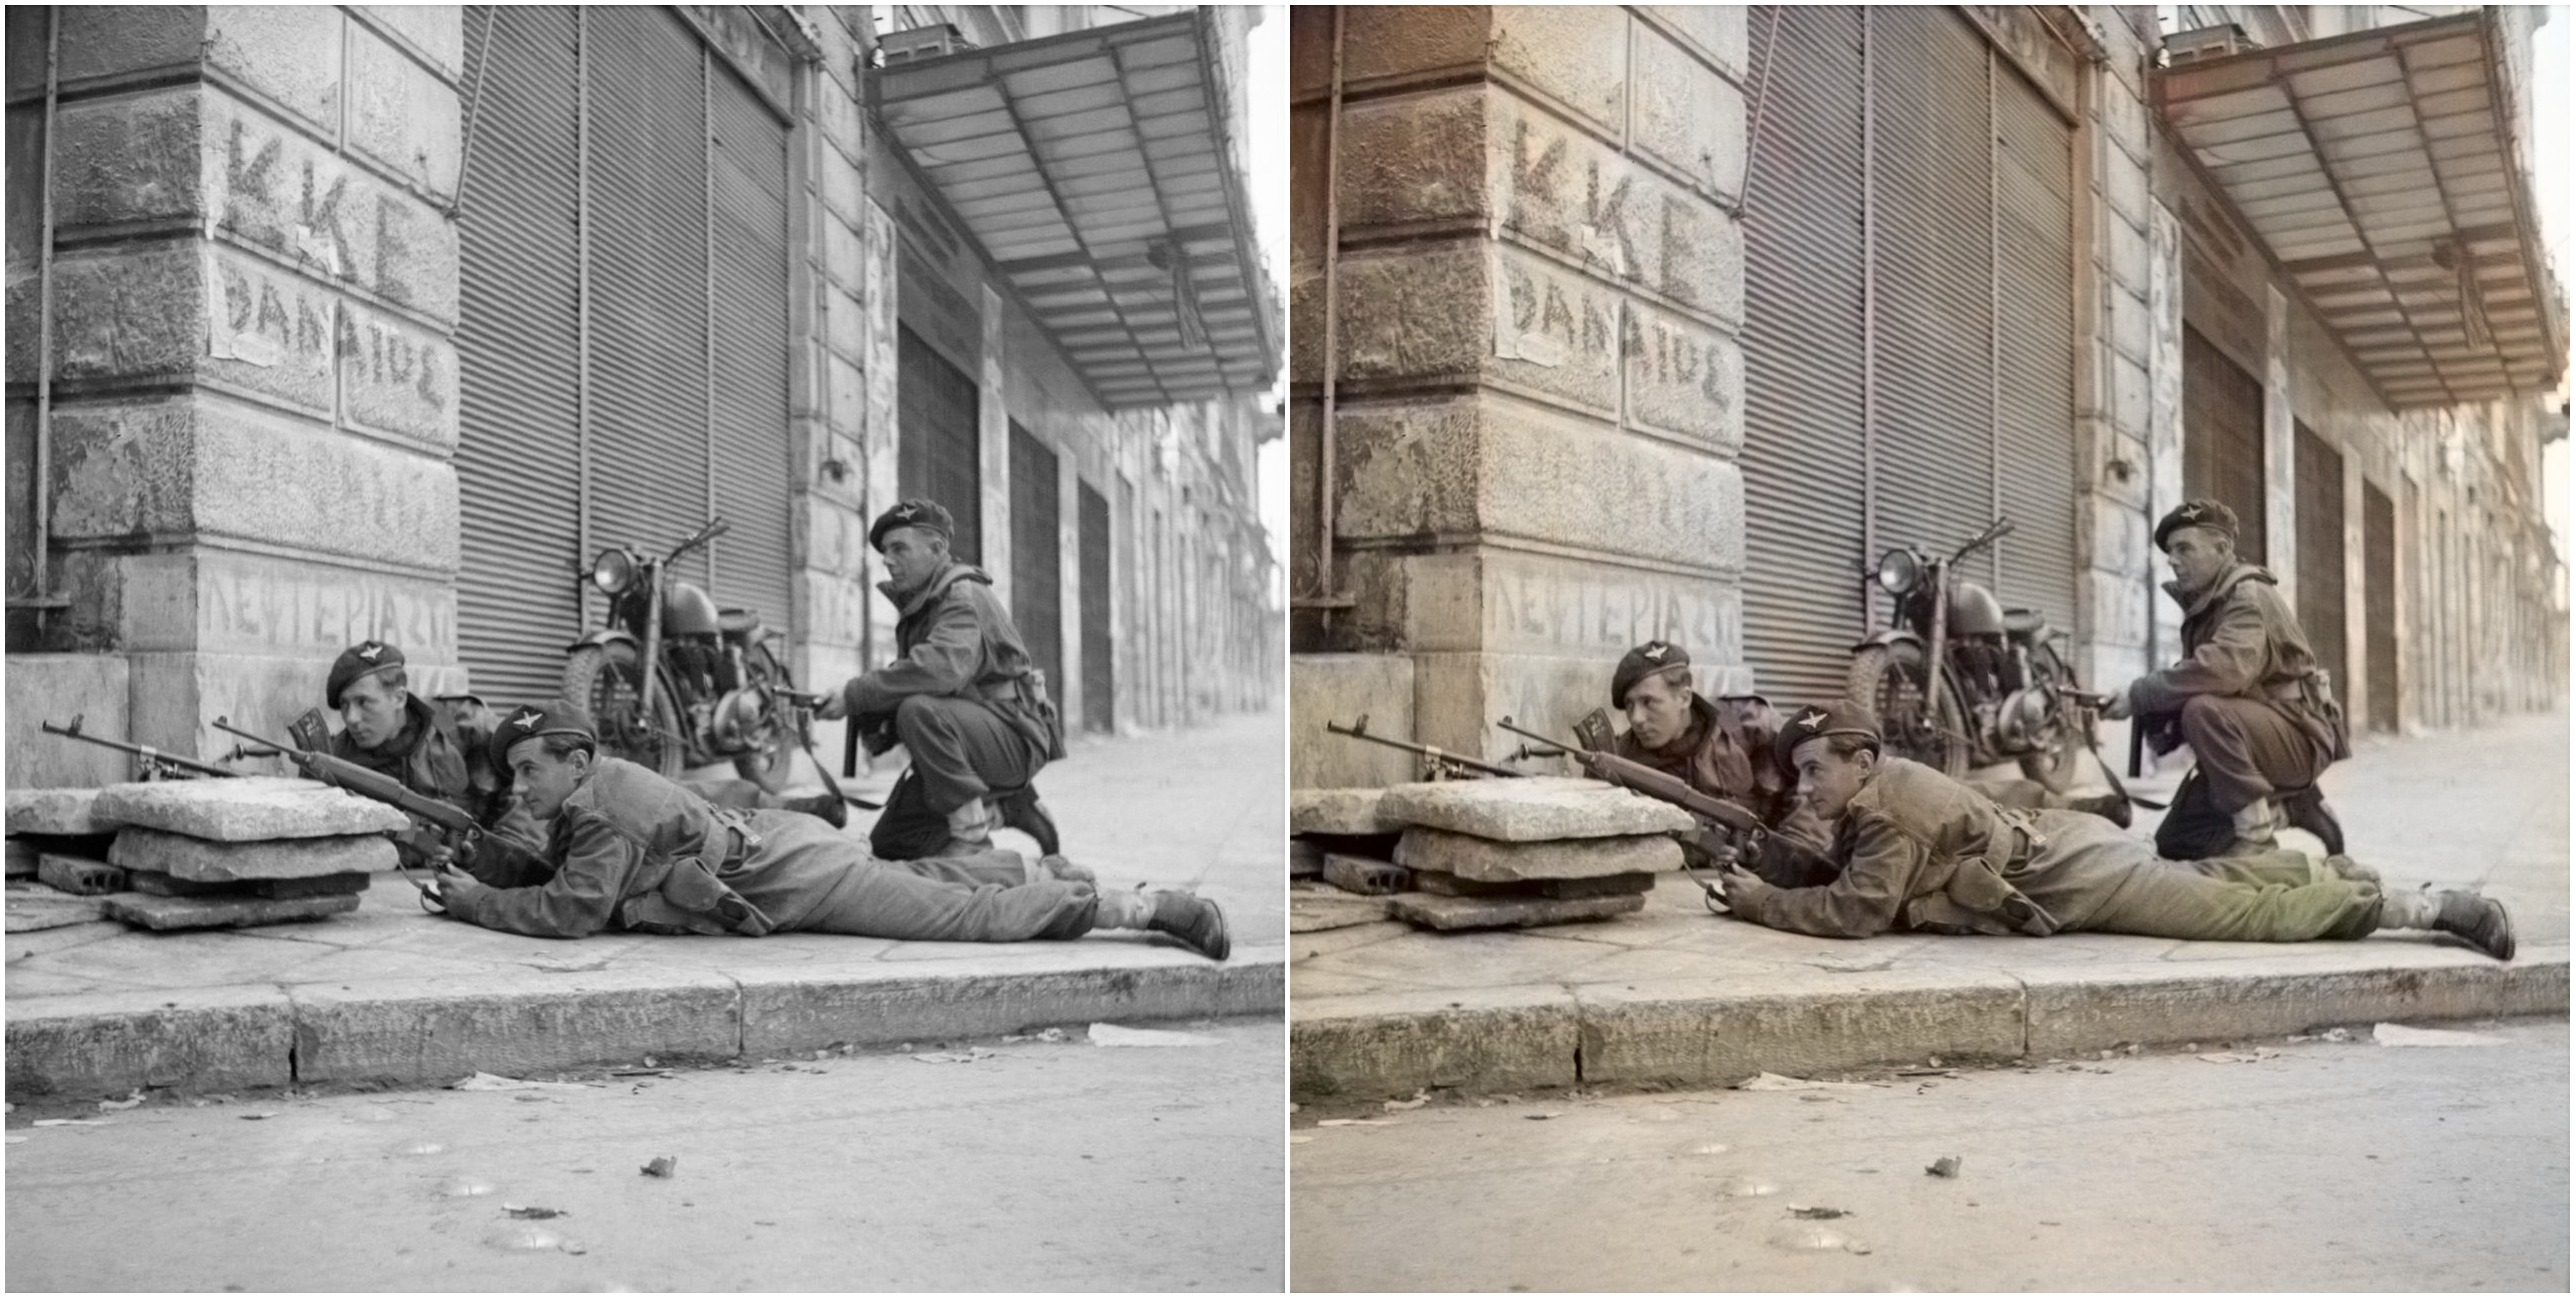

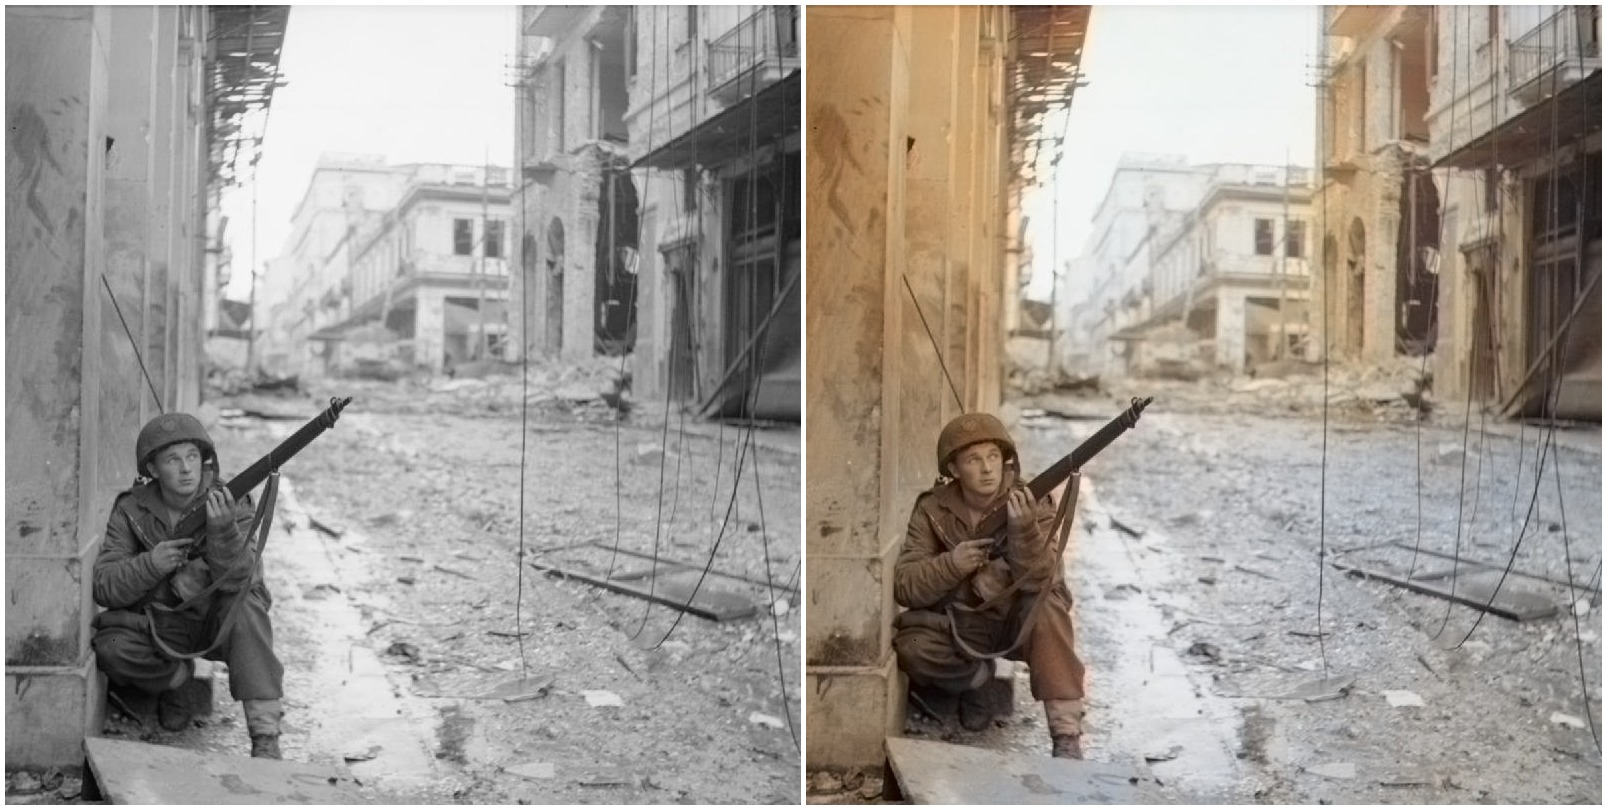

___